### Using FireScore Point Cloud Data

This notebook demonstrates how to access, process and display large point cloud data efficiently from the Firescore public S3 bucket or local copy of the data. 

In [34]:
ept_url = "s3://firescore-open-data/la_habra_heights_ca/usgs_lidar/ept.json"

This point cloud data was originally sourced from USGS LIDAR repositories.  <br>The Firescore team has removed anomalous values and computed a ground model and heights above ground.  We also classified the points based on the combination point features and data conflation with super-resolution of Sentinel-2 imagery.<br> 
The resulting point clouds have following classification code values:

<ul>
    <li>Ground - 2</li>
<li>Buildings - 6</li>
<li>Low Vegetation (<1m) - 3</li>
    <li>High Vegetation (>=1,) - 4</li>
<li>Unclassified - 1</li></ul>

#### Imports

 Note: if you want to isolate these installations to avoid conflicts, first use your local environment manager to create an environment before running installs

In [35]:
import json
import pandas as pd

# for optional extraction of building convex hulls
from shapely.geometry import MultiPoint
import numpy as np

In [53]:
try:
    import matplotlib
except:
    print(f"Installing matplotlib")
    %pip install matplotlib
    import matplotlib.pyplot as plt
print(f"Using matplotlib version {matplotlib.__version__}")

Using matplotlib version 3.10.3


In [36]:
try:
    import pdal
except:
    print(f"Installing pdal")
    %pip install pdal
    import pdal
print(f"Using pdal version {pdal.__version__}")

Using pdal version 3.4.5


In [37]:
try:
    import s3fs
except:
    print(f"Installing s3fs")
    %pip install s3fs
    import s3fs
print(f"Using s3fs version {s3fs.__version__}")

Using s3fs version 2025.5.1


In [38]:
# Initialize S3 filesystem with credentials
try:
    fs = s3fs.S3FileSystem(anon=True)
    print("Initialized s3 filesystem")
except:
    print("Problem initializing s3 filesystem")

Initialized s3 filesystem


#### Example load of local data

In [45]:
# adjust this to point to location of downloaded data or cloned repro
local_storage = "/Users/mflaxman/consulting/cortex/Web/open_data/la_habra_heights_ca/usgs_lidar/ept-data"
example_tile = f"{local_storage}/0-0-0-0.laz"
!pdal info {example_tile}

{
  "file_size": 580464,
  "filename": "/Users/mflaxman/consulting/cortex/Web/open_data/la_habra_heights_ca/usgs_lidar/ept-data/0-0-0-0.laz",
  "now": "2025-05-29T11:04:59-0700",
  "pdal_version": "2.8.4 (git-version: Release)",
  "reader": "readers.las",
  "stats":
  {
    "bbox":
    {
      "EPSG:4326":
      {
        "bbox":
        {
          "maxx": -117.9546912,
          "maxy": 33.96885716,
          "maxz": 349.14,
          "minx": -117.9642665,
          "miny": 33.96125772,
          "minz": 186.71
        },
        "boundary": { "type": "Polygon", "coordinates": [ [ [ -117.964266512737922, 33.961257719604475, 186.71 ], [ -117.964266512737922, 33.968857161634205, 186.71 ], [ -117.954691190461446, 33.968857161634205, 349.14 ], [ -117.954691190461446, 33.961257719604475, 349.14 ], [ -117.964266512737922, 33.961257719604475, 186.71 ] ] ] }
      },
      "native":
      {
        "bbox":
        {
          "maxx": -13130656.16,
          "maxy": 4024621.07,
          "max

#### Read and Print Remote Data and Metadata

Note: the metadata in EPT files allows easily determining geographic bounds without loading full datasets

In [41]:
# this is important to allow anonymous access to s3 buckets within PDAL

In [39]:
import os
os.environ["AWS_NO_SIGN_REQUEST"] = "YES"

In [46]:
metadata = ""
try:
    with fs.open(ept_url, "r") as f:
        metadata = json.load(f)
    bounds = metadata["bounds"]
    minx, miny, _, maxx, maxy, _ = bounds
    print("Raw bounds:", (minx, miny, maxx, maxy))
    # 5) Get the EPSG code from the JSON
    epsg_source = metadata["srs"]["horizontal"]
    print("Source EPSG:", epsg_source)
except Exception as e:
    print(f"Problem accessing s3 EPT at {ept_url}, please check path or network.  \nError reported: {str(e)}")

Raw bounds: (-13131723, 4023577, -13130655, 4024645)
Source EPSG: 3857


#### Read (building class) data using Pdal pipeline
This extracts just building points and saves them to local LAZ file

In [47]:
pipeline = {
            "pipeline": 
            [
                
                {
                    "type": "readers.ept",
                    "filename": ept_url
                },
                ###### Optionally select classification 6 ###############
                {
                    "type":"filters.range",
                    "limits":"Classification[6:6]" ### Classification 6 is for buildings
                },
                ##########################################################
                {
                    "type": "writers.las",
                    "compression": "true",
                    "minor_version": "2",
                    "dataformat_id": "3",
                    "forward": "all",
                    "extra_dims": "all",
                    "filename": f"la_habra_building_heights.laz"
                },
                 
            ]
        }
p = pdal.Pipeline(json.dumps(pipeline))
try:
    count = p.execute()
    print(f"✅ Saved building with {count} points")
except RuntimeError as e:
    print(f"⚠️  Skipping building reading due to error: {e}")

✅ Saved building with 143447 points


#### Save the data into a dataframe

In [48]:
data_array = p.arrays[0]
description = data_array.dtype.descr
cols = [col for col, __ in description]
df_pcd = pd.DataFrame({col: data_array[col] for col in cols})

In [50]:
df_pcd.columns

Index(['Blue', 'Classification', 'EdgeOfFlightLine', 'GpsTime', 'Green',
       'HeightAboveGround', 'Intensity', 'KeyPoint', 'NumberOfReturns',
       'OriginId', 'Overlap', 'PointSourceId', 'Red', 'ReturnNumber',
       'ScanAngleRank', 'ScanDirectionFlag', 'Synthetic', 'UserData',
       'Withheld', 'X', 'Y', 'Z'],
      dtype='object')

In [49]:
df_pcd.head(5)

,Blue,Classification,EdgeOfFlightLine,GpsTime,Green,HeightAboveGround,Intensity,KeyPoint,NumberOfReturns,OriginId,...,Red,ReturnNumber,ScanAngleRank,ScanDirectionFlag,Synthetic,UserData,Withheld,X,Y,Z
0,0,6,0,1.303157e+08,0,2.834306,1616,0,1,0,...,0,1,10.0,0,0,0,0,-13130889.65,4024591.78,324.89
1,0,6,0,1.303157e+08,0,3.321141,448,0,2,0,...,0,1,10.0,0,0,0,0,-13130888.97,4024594.58,325.37
2,0,6,0,1.303157e+08,0,3.155070,1488,0,1,0,...,0,1,10.0,0,0,0,0,-13130888.85,4024593.65,325.24
3,0,6,0,1.303157e+08,0,2.033594,3296,0,1,0,...,0,1,10.0,0,0,0,0,-13130886.20,4024573.11,323.85
4,0,6,0,1.303157e+08,0,2.126245,3616,0,2,0,...,0,2,10.0,0,0,0,0,-13130885.95,4024571.22,323.85


#### Optionally Plot a subset of points

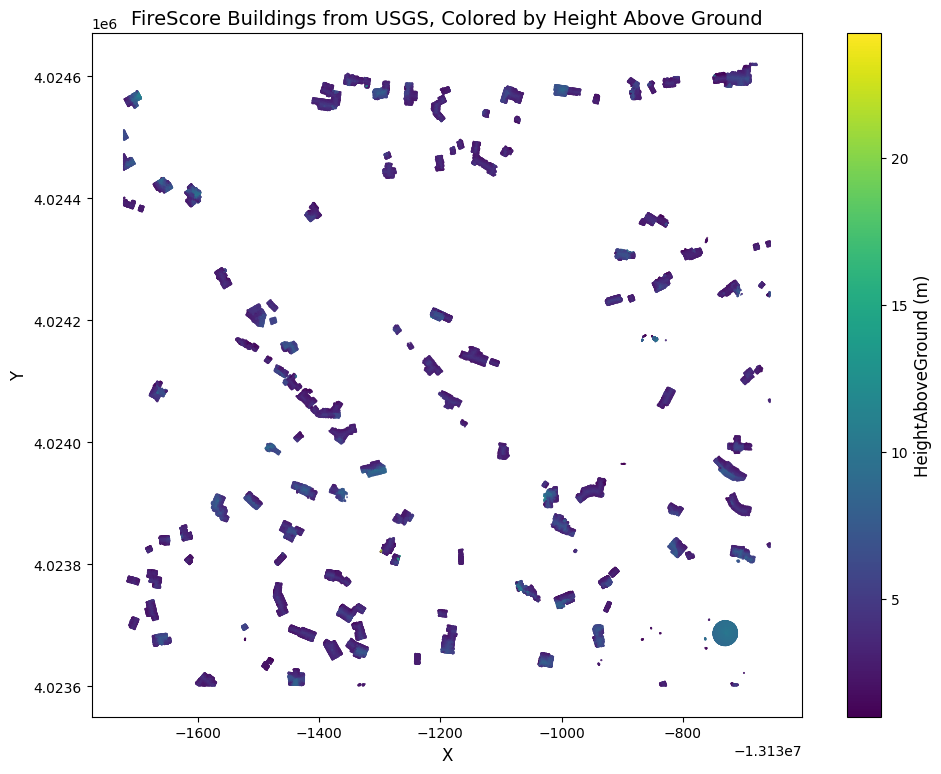

In [55]:
# 5) Make the scatter plot, rasterized to speed up rendering
fig, ax = plt.subplots(figsize=(10, 8))
sc = ax.scatter(
    df_pcd['X'],
    df_pcd['Y'],
    c=df_pcd['HeightAboveGround'],
    s=0.5,
    marker='.',
    rasterized=True
)

# 6) Colorbar & labels
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('HeightAboveGround (m)', fontsize=12)
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_title('FireScore Buildings from USGS, Colored by Height Above Ground', fontsize=14)

plt.tight_layout()
plt.show()